![alt text](il_570xN.5204997740_q57i-1.webp)

In [1]:
from google.colab import files
files.upload()   # kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hossamheltohamy27","key":"c2d34c6704df24b14b255b89f50daf06"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



In [3]:
!kaggle datasets download -d grassknoted/asl-alphabet
!unzip asl-alphabet.zip -d asl_alphabe

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabe/asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabe/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabe/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabe/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabe/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabe/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabe/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabe/asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabe/asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabe/asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabe/asl_alphabet_train/asl_alphabet_train

#*Key_Points*

In [4]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 10.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.12.0.88
    Uninstalling open

In [1]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import random
import os
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix



In [2]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)


In [3]:
data_dir = "/content/asl_alphabe/asl_alphabet_train/asl_alphabet_train"
classes = os.listdir(data_dir)
print(classes)

['Q', 'U', 'A', 'del', 'nothing', 'F', 'V', 'B', 'S', 'H', 'C', 'Z', 'D', 'N', 'L', 'Y', 'I', 'E', 'J', 'T', 'O', 'R', 'P', 'W', 'G', 'space', 'M', 'K', 'X']


In [7]:
X = []
y = []

for label in classes:
    folder_path = os.path.join(data_dir, label)
    for img_name in tqdm(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        results = hands.process(img_rgb)

        if results.multi_hand_landmarks:
            hand_landmarks = results.multi_hand_landmarks[0]
            keypoints = []
            for lm in hand_landmarks.landmark:
                keypoints.extend([lm.x, lm.y, lm.z])
            X.append(keypoints)
            y.append(label)


100%|██████████| 3000/3000 [01:34<00:00, 31.85it/s]


In [8]:
X = np.array(X)
y = np.array(y)

np.save("X_keypoints.npy", X)
np.save("y_labels.npy", y)

print("✅ Data saved successfully!")


✅ Data saved successfully!


In [ ]:
X = np.load("X_keypoints.npy")
y = np.load("y_labels.npy")

print("X shape:", X.shape)
print("y shape:", y.shape)


In [9]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)
X = np.array(X)


In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

num_classes = len(classes)

model = models.Sequential([
    layers.Input(shape=(63,)),      # 21 joint * 3
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 29)             │         1,885 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,333 (71.61 KB)

 Trainable params: 18,333 (71.61 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y_categorical, test_size=0.15, random_state=42)

In [14]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32
)


Epoch 1/30
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9586 - loss: 0.1420 - val_accuracy: 0.9838 - val_loss: 0.0719
Epoch 2/30
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9617 - loss: 0.1353 - val_accuracy: 0.9686 - val_loss: 0.1014
Epoch 3/30
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9603 - loss: 0.1442 - val_accuracy: 0.9839 - val_loss: 0.0701
Epoch 4/30
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9606 - loss: 0.1384 - val_accuracy: 0.9856 - val_loss: 0.0649
Epoch 5/30
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9600 - loss: 0.1341 - val_accuracy: 0.9851 - val_loss: 0.0670
Epoch 6/30
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9608 - loss: 0.1297 - val_accuracy: 0.9796 - val_loss: 0.0784
Epoch 7/30
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9616 - loss: 0.1347 - val_accuracy: 0.9851 - val_loss: 0.0667
Epoch 8/30
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9633 - loss: 0.1281 - 

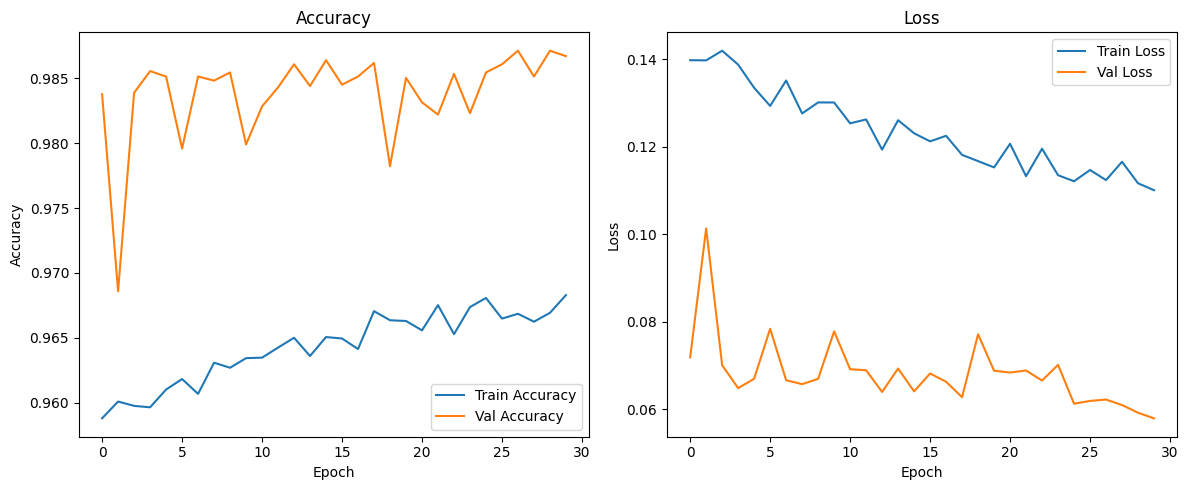

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy subplot
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Loss subplot
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Val Loss')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
📊 Model Evaluation Results:
✅ Accuracy : 0.9867
🎯 Precision: 0.9869
🔁 Recall   : 0.9867
🔥 F1-score : 0.9867


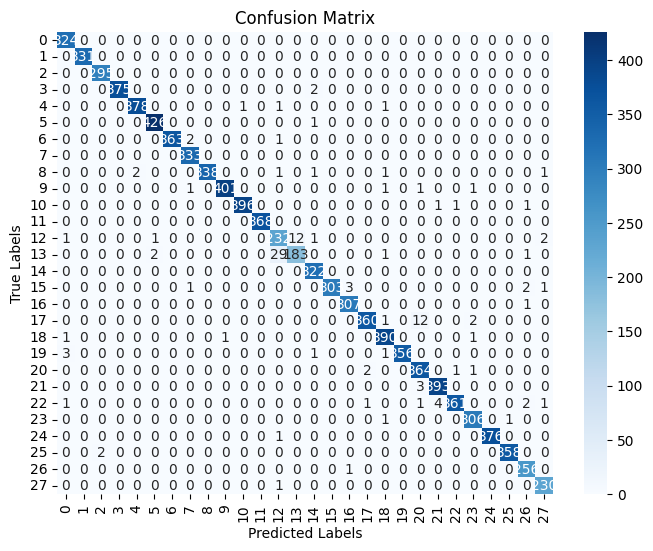

In [16]:

y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)


accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print("📊 Model Evaluation Results:")
print(f"✅ Accuracy : {accuracy:.4f}")
print(f"🎯 Precision: {precision:.4f}")
print(f"🔁 Recall   : {recall:.4f}")
print(f"🔥 F1-score : {f1:.4f}")

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 64
num_classes = 29
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  # 20%
)

train_generator = train_datagen.flow_from_directory(
    '/content/asl_alphabe/asl_alphabet_train/asl_alphabet_train',  #change
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 69600 images belonging to 29 classes.


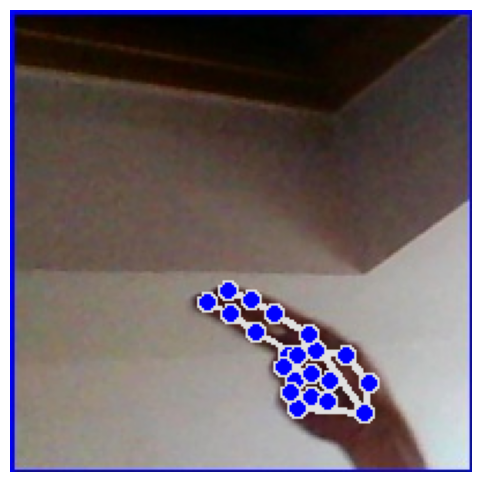

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
Predicted letter: H true : H


In [20]:

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)

model = load_model("asl_keypoints_model.h5")

class_name = random.choice(list(train_generator.class_indices.keys()))
img_name = random.choice(os.listdir(os.path.join("/content/asl_alphabe/asl_alphabet_train/asl_alphabet_train", class_name)))
img_path = os.path.join("/content/asl_alphabe/asl_alphabet_train/asl_alphabet_train", class_name, img_name)

img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

results = hands.process(img_rgb)

if results.multi_hand_landmarks:
    hand_landmarks = results.multi_hand_landmarks[0]

    img_plot = img_rgb.copy()
    mp_drawing.draw_landmarks(img_plot, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    plt.figure(figsize=(6,6))
    plt.imshow(img_plot)
    plt.axis("off")
    plt.show()

    keypoints = []
    for lm in hand_landmarks.landmark:
        keypoints.extend([lm.x, lm.y, lm.z])
    keypoints = np.array(keypoints).reshape(1, 63)
    model = load_model("asl_keypoints_model.h5")
    pred = model.predict(keypoints)
    pred_class = np.argmax(pred)

    class_indices = train_generator.class_indices
    inv_class_indices = {v: k for k, v in class_indices.items()}
    pred_letter = inv_class_indices[pred_class]

    print("Predicted letter:", pred_letter,"true :",class_name )
else:
    print("No hand detected")


In [ ]:
model.save("asl_keypoints_model.h5")


In [ ]:
!pip install streamlit streamlit_webrtc

#sample app

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import mediapipe as mp

model = tf.keras.models.load_model("asl_keypoints_model.h5")
class_names = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z","del","nothing","space"]

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    results = hands.process(rgb)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            keypoints = []
            for lm in hand_landmarks.landmark:
                keypoints.extend([lm.x, lm.y, lm.z])

            keypoints = np.array(keypoints).reshape(1, 63)

            pred = model.predict(keypoints)
            pred_class = np.argmax(pred)

            cv2.putText(frame, f"Class: {class_names[pred_class]}", (20, 40),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    cv2.imshow("ASL Prediction", frame)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()


***FINSH***